<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left">ANÁLISIS EXPLORATORIO DE DATOS (EDA)</h3></font>

## Importar librerias

En esta primera parte del código, se realizan las llamadas a las librerías:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Importar DataSet

Para desarrollar la iniciativa, se ha elegido un dataset generado a partir del simulador **PaySim**, que genera conjuntos de datos sintéticos similares a los conjuntos de datos reales de las transacciones de dinero móvil. PaySim utiliza datos agregados para generar un conjunto de datos sintéticos que se asemeje al funcionamiento normal de las transacciones y además inyecte comportamientos maliciosos.

En este caso, la muestra extraída corresponde a 1 mes de un servicio de dinero móvil implementado en un país africano.

*PaySim first paper of the simulator:
E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016*

In [2]:
s3 = boto3.client("s3")

In [3]:
# Metemos en la variable res, el nombre de todos los buckets que tenemos en nuestra máquina de AWS
res = s3.list_buckets()

In [4]:
# Mostramos los distintos buckets que tenemos en S3
res["Buckets"]

[{'Name': 'aasmbitschool',
  'CreationDate': datetime.datetime(2020, 3, 23, 18, 17, 50, tzinfo=tzlocal())},
 {'Name': 'tfmfraud',
  'CreationDate': datetime.datetime(2020, 8, 12, 10, 27, 52, tzinfo=tzlocal())}]

In [5]:
# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [6]:
# Listamos los ficheros que tenemos dentro del bucket que hemos solucionado.
s3.list_objects(Bucket = BUCKET_NAME)

{'ResponseMetadata': {'RequestId': 'CDBC40E8ED64C575',
  'HostId': 'TzjQFzWIMMyZ+KXbH/JN46slNJ9dDMa5lhX4/EARVA9SyhxzUjru0NSQQlA/mTHSe1d19BbrCMk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'TzjQFzWIMMyZ+KXbH/JN46slNJ9dDMa5lhX4/EARVA9SyhxzUjru0NSQQlA/mTHSe1d19BbrCMk=',
   'x-amz-request-id': 'CDBC40E8ED64C575',
   'date': 'Wed, 12 Aug 2020 16:33:40 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'dataset_v0.csv',
   'LastModified': datetime.datetime(2020, 8, 12, 10, 43, 49, tzinfo=tzlocal()),
   'ETag': '"3ad3f545cf41c2d46802c39d6c6e6d3e-29"',
   'Size': 493534783,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'awslabsc0w601512t1581883282',
    'ID': 'd79b5e3eed7c637ad447a28498162e365200293b12dd2095a264060d2a7898d4'}},
  {'Key': 'df_dirty.csv',
   'LastModified': datetime.datetime(20

In [7]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'df_dirty.csv',Filename = '/tmp/df_dirty.csv')

In [8]:
# Listamos los ficheros que hay en la ruta /tmp. Esta ruta es donde hemos descargado nuestro fichero de s3
!ls /tmp

dataset_v0.csv
df_dirty.csv
systemd-private-6c440eefc28c4d319793e82277e9b4cc-chronyd.service-MUrd4O


In [15]:
#Leemos el fichero y lo metemos en un dataframe.
df_dirty = pd.read_csv('/tmp/df_dirty.csv', dtype={'rank':'category'})

## Análisis Exploratorio de Datos (EDA)

El análisis exploratorio tiene como objetivo identificar las características del dataframe, tales como: outliers, missing, discontinuidades, concentraciones de valores, etc. Para ello vamos a seguir diferentes estudios sobre los datos:
* *Estudio de la dimensión del dataframe*
* *Estudio de datos perdidos*
* *Estudio de duplicidades*
* *Estudio de datos de tipo outlier en variables continuas*
* *Estudio de datos de tipo outlier en variables discretas*
* *Estudio de datos de tipo outlier en la variable type*
* *Identificación de campos/variables con un único valor*

### Análisis Exploratorio de Datos (EDA)

En primer lugar, tomamos **sensibilidad del dataset de trabajo** y obtenemos una muestra de los datos:

In [16]:
print("Tamaño dataset del dataset:", df_dirty.shape)
print("Número de variables/predictores (columnas):", df_dirty.shape[1])
print("Número de registros (instancias/filas):", df_dirty.shape[0])

Tamaño dataset del dataset: (6617125, 11)
Número de variables/predictores (columnas): 11
Número de registros (instancias/filas): 6617125


In [17]:
df_dirty.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


Para simular el servicio de dinero móvil, se necesitan simular adecuadamente los diferentes tipos de transacciones que el sistema soporta. En el simulador **PaySim** se ha decidido cubrir 5 de los tipos de transacciones más importantes: CASH-IN, CASH-OUT, DEBIT, PAYMENT y TRANSFER. Estas categorías se recogen en la variable *type*:
* CASH-IN - Proceso de aumentar el balance de una cuenta pagando en efectivo a un comerciante
* CASH-OUT - Proceso opuesto a CASH-IN. Supone retirar dinero de la cuenta de un comerciante, disminuyendo el balance de la misma
* DEBIT - Similar a CASH-OUT. Consiste en enviar el dinero del servicio de dinero móvil a una cuenta bancaria
* PAYMENT - Proceso de pagar por bienes o servicios a los comerciantes que disminuye el saldo de la cuenta y aumenta el saldo del receptor
* TRASNFER - Proceso de enviar dinero a otro usuario del servicio a través de la plataforma de dinero móvil

Adicionalmente, el dataset cuenta con 9 variables más que determinan el movimiento financiero:
* *Amount* - Importe de la operación en moneda local
* *nameOrig* - Cliente que inició la operación
* *oldbalanceOrig* - Saldo inicial antes de la transacción en la cuenta de origen
* *newbalanceOrig* - Nuevo saldo después de la transacción en la cuenta de origen
* *nameDest* - Cliente destinatario de la operación
* *oldbalanceDest* - Saldo inicial del receptor antes de la transacción
* *newbalanceDest* - Nuevo saldo del receptor después de la transacción
* *isFraud* - Indicador de transacción realizadas por agentes fraudulentos
* *isFlaggedFraud* - Indicador de transacción ilegal. El modelo de negocio tiene como objetivo controlar las transferencias masivas de una cuenta a otra y marca los intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200.000 en una sola transacción.

Y una variable que indica el momento de tiempo en que se realizó el movimiento, *step*. Esta variable mapea 1 hora de tiempo real. El dataset contiene información de 31 días, por lo que en el data set encontramos 743 steps.

Una vez conocida la estructura del dataframe, continuamos realizando el análisis, identificando la **tipología de las variables**:

In [18]:
df_dirty.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object

Para analizar la calidad del dataset, es necesario evaluar el volumen de datos ausentes, outliers, filas duplicadas, variables con un unico valor, etc. que se realizarán en los próximos pasos.

### Estudio de datos perdidos

En primer lugar, evaluamos la existencia de datos missing ejecutando el siguiente comando:

In [19]:
df_dirty.isnull().values.any()

True

El comando `.any()`, nos devolverá *True* si hay algún valor NaN en nuestro DataFrame.  

Una vez identificada la existencia de datos perdios, analizamos el total de datos perdidos que se encuentran en el dataframe, respondiendo a las siguientes preguntas:

* ¿Qué volumen total de datos missing hay en el dataset?

In [20]:
df_dirty.isnull().sum().sum()

229775

* ¿Cuál es la distribución de valores perdidos por columna?

In [21]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores Missing', 1 : '% Total Valores'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% Total Valores', ascending=False).round(1)
    print ("El data frame contiene " + str(df.shape[1]) + " columnas.\n"      
           "Hay " + str(mis_val_table_ren_columns.shape[0]) +
           " columnas que tienen valores perdidos.")
    return mis_val_table_ren_columns

In [22]:
missing_values_table(df_dirty)

El data frame contiene 11 columnas.
Hay 9 columnas que tienen valores perdidos.


,Valores Missing,% Total Valores
nameOrig,25811,0.4
oldbalanceOrg,25691,0.4
nameDest,25585,0.4
isFlaggedFraud,25580,0.4
amount,25469,0.4
oldbalanceDest,25452,0.4
newbalanceDest,25450,0.4
isFraud,25419,0.4
newbalanceOrig,25318,0.4


* ¿Qué porcentaje de valores missing hay con respecto al total de valores?

In [23]:
#Calculamos el total de datos:
total_cells = np.product(df_dirty.shape)
#Calculamos el total de valores missing, sumando todos los valores de la variable que contiene los missing para cada columna:
missing_values_count = df_dirty.isnull().sum()
total_missing = missing_values_count.sum()
# Calculamos el porcentaje de valores perdidos con respecto al total de valores del dataframe:
(total_missing/total_cells)*100

0.31567540833271795

El 31,56% (229.775 celdas) de los valores del dataframe son missing. Lo importante una vez hemos detectado la existencia de datos missing es determinar qué hacer con ellos.Para ello, debemos de analizar la distribución de estos datos en el dataframe para así poder determinar si se eliminan o se imputan.  

Para afinar en nuestra búsqueda del valor NaN perdido podemos extraer las filas que contengan valores NaN:

In [24]:
nan_rows = df_dirty[df_dirty.isnull().any(1)]
print("Número de registros (instancias/filas):", nan_rows.shape[0])

Número de registros (instancias/filas): 156227


Puesto que unicamente encontramos 156.227 filas con valores missing, lo que corresponde a un 2,4% del total de filas del dataframe original, procedemos a eliminar esas filas:

In [25]:
df_sin_nan = df_dirty.dropna(how='any')
print("Número de registros (instancias/filas):", df_sin_nan.shape[0])

Número de registros (instancias/filas): 6460898


Nuestro nuevo dataframe, limpio de missing, contiene 6.460.898 de filas. Comprobamos si existen valores missing:

In [26]:
df_sin_nan.isnull().values.any()

False

Nuestro dataframe ya está limpio de datos perdidos.

### Estudio de duplicidades

El siguiente paso, consiste en identificar la existencia de filas duplicadas. En primer lugar, evaluamos la existencia de filas duplicadas (registro completo). Para ello, ejecutamos el siguiente comando:

In [27]:
df_sin_nan.duplicated().sum()

98278

Existen 98.278 (1,5% del total) filas duplicadas en el daframe. Eliminamos estas filas:

In [28]:
df_sin_duplicados = df_sin_nan.drop_duplicates()
print("Número de registros (instancias/filas):", df_sin_duplicados.shape[0])

Número de registros (instancias/filas): 6362620


El nuevo dataset contiene 6.362.620 registros.

### Estudio de datos de tipo outlier en variables continuas

Para identificar outliers en las variables, pintamos los gráficos boxplot de las variable continuas: *amount*, *oldbalanceOrg*, *newbalanceOrig*, *oldbalanceDest*, *newbalanceDest*.

 * **Boxplot para la variable amount**

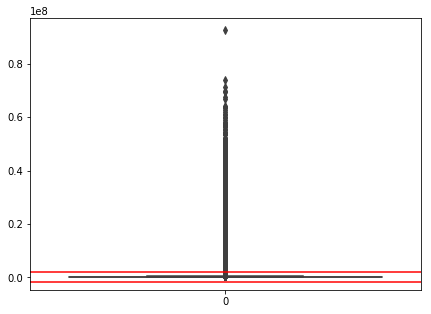

In [29]:
plt.figure(figsize=(7,5))
sns.boxplot(data = df_sin_duplicados['amount'])
plt.axhline(y=np.mean(df_sin_duplicados['amount']) + 3*np.std(df_sin_duplicados['amount']), color='r')
plt.axhline(y=np.mean(df_sin_duplicados['amount']) - 3*np.std(df_sin_duplicados['amount']), color='r')
plt.show()

Como se puede observar, aplicando los límites mediante el cálculo de la desviación seis sigma (±3 veces la desviación típica), la variable *amount* (Importe de la operación en moneda local) toma valores positivos y presenta outliers. Al tratarse de un dataset con posibles transacciones fraudulentas, es normal que esta variable contenga datos atípicos (correspondientes a transacciones de cantidades monetarias altas). Al no encontrar valores negativos, caso que sí podríamos considerar outlier, no nos interesa trabajar sobre estos valores ya que el objeto de este trabajo es aprender a identificar y predecir. posibles transacciones fraudulentas.

 * **Boxplot para la variable oldbalanceOrg**

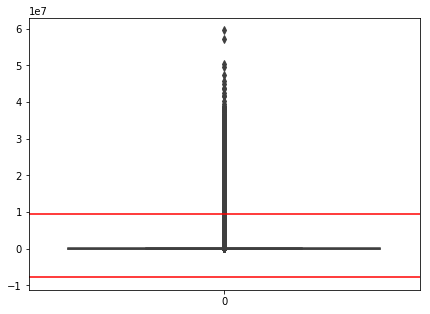

In [30]:
plt.figure(figsize=(7,5))
sns.boxplot(data = df_sin_duplicados['oldbalanceOrg'])
plt.axhline(y=np.mean(df_sin_duplicados['oldbalanceOrg']) + 3*np.std(df_sin_duplicados['oldbalanceOrg']), color='r')
plt.axhline(y=np.mean(df_sin_duplicados['oldbalanceOrg']) - 3*np.std(df_sin_duplicados['oldbalanceOrg']), color='r')
plt.show()

Como se puede observar, aplicando los límites mediante el cálculo de la desviación seis sigma (±3 veces la desviación típica), la variable *oldbalanceOrg* (Saldo inicial antes de la transacción en la cuenta de origen) toma valores positivos y presenta outliers. Al tratarse de un dataset con posibles transacciones fraudulentas, es normal que esta variable contenga datos atípicos (correspondientes a saldos altos en cuenta origen). Al no encontrar valores negativos, caso que sí podríamos considerar outlier, no nos interesa trabajar sobre estos valores ya que el objeto de este trabajo es aprender a identificar y predecir posibles transacciones fraudulentas.

 * **Boxplot para la variable newbalanceOrig**

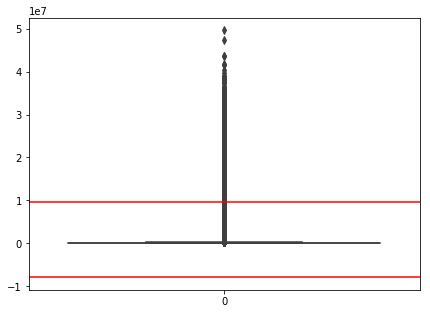

In [31]:
plt.figure(figsize=(7,5))
sns.boxplot(data = df_sin_duplicados['newbalanceOrig'])
plt.axhline(y=np.mean(df_sin_duplicados['newbalanceOrig']) + 3*np.std(df_sin_duplicados['newbalanceOrig']), color='r')
plt.axhline(y=np.mean(df_sin_duplicados['newbalanceOrig']) - 3*np.std(df_sin_duplicados['newbalanceOrig']), color='r')
plt.show()

Como se puede observar, aplicando los límites mediante el cálculo de la desviación seis sigma (±3 veces la desviación típica), la variable *newbalanceOrig* (Nuevo saldo después de la transacción en la cuenta de origen) toma valores positivos y presenta outliers. Al no encontrar valores negativos, caso que sí podríamos considerar outlier, no nos interesa trabajar sobre estos valores ya que el objeto de este trabajo es aprender a identificar y predecir posibles transacciones fraudulentas.

 * **Boxplot para la variable oldbalanceDest**

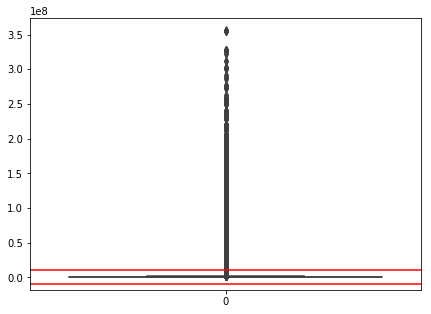

In [32]:
plt.figure(figsize=(7,5))
sns.boxplot(data = df_sin_duplicados['oldbalanceDest'])
plt.axhline(y=np.mean(df_sin_duplicados['oldbalanceDest']) + 3*np.std(df_sin_duplicados['oldbalanceDest']), color='r')
plt.axhline(y=np.mean(df_sin_duplicados['oldbalanceDest']) - 3*np.std(df_sin_duplicados['oldbalanceDest']), color='r')
plt.show()

Como se puede observar, aplicando los límites mediante el cálculo de la desviación seis sigma (±3 veces la desviación típica), la variable *oldbalanceDest* (Saldo inicial del receptor antes de la transacción) toma valores positivos y presenta outliers. Al no encontrar valores negativos, caso que sí podríamos considerar outlier, no nos interesa trabajar sobre estos valores ya que el objeto de este trabajo es aprender a identificar y predecir posibles transacciones fraudulentas.

 * **Boxplot para la variable newbalanceDest**

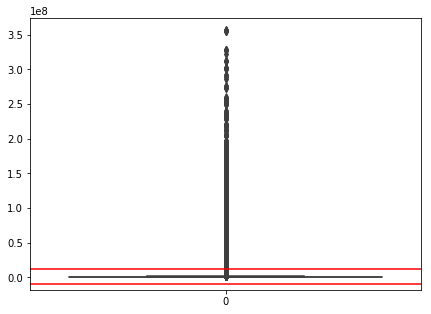

In [33]:
plt.figure(figsize=(7,5))
sns.boxplot(data = df_sin_duplicados['newbalanceDest'])
plt.axhline(y=np.mean(df_sin_duplicados['newbalanceDest']) + 3*np.std(df_sin_duplicados['newbalanceDest']), color='r')
plt.axhline(y=np.mean(df_sin_duplicados['newbalanceDest']) - 3*np.std(df_sin_duplicados['newbalanceDest']), color='r')
plt.show()

Como se puede observar, aplicando los límites mediante el cálculo de la desviación seis sigma (±3 veces la desviación típica), la variable newbalanceDest (Nuevo saldo del receptor después de la transacción) toma valores positivos y presenta outliers. Al no encontrar valores negativos, caso que sí podríamos considerar outlier, no nos interesa trabajar sobre estos valores ya que el objeto de este trabajo es aprender a identificar y predecir posibles transacciones fraudulentas.

### Estudio de datos de tipo outlier en variables discretas

Para analizar la existencia de datos de tipo outlier en las variables discretas: *isFraud* (Indicador de transacción realizadas por agentes fraudulentos) e *isFlaggedFraud* (Indicador de transacción ilegal), analizaremos la exitencia de valores distintos a 0 o 1.

In [34]:
df_sin_duplicados[["nameOrig"]].groupby(df_sin_duplicados['isFraud']).count()

,nameOrig
isFraud,
0.0,6354407
1.0,8213


In [35]:
df_sin_duplicados[["nameOrig"]].groupby(df_sin_duplicados['isFlaggedFraud']).count()

,nameOrig
isFlaggedFraud,
0.0,6362604
1.0,16


Como se observa, las variables *isFraud* e *isFlaggedFraud* únicamente toman valores 0 ó 1.

### Estudio de datos de tipo outlier en la variable type

La variable type, indica el tipo de transacción que se ha realizado. Según la bibliografía, esta variable sólo puede tomas 5 valores. Vamos a comprobarlo realizando el mismo análisis que en el caso anterior:

In [36]:
df_sin_duplicados[["nameOrig"]].groupby(df_sin_duplicados['type']).count()

,nameOrig
type,
CASH_IN,1399284
CASH_OUT,2237500
DEBIT,41432
PAYMENT,2151495
TRANSFER,532909


Como se observa, la variable type, unicamente tomas los valores descritos en la bibliografía.

### Identificación de campos/variables con un único valor

Evaluamos la exitencia de vairables que toman un único valor:

In [37]:
df_sin_duplicados.apply(pd.Series.nunique) == 1

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

No existen campos que tomen un solo valor

## Exportamos el dataset

Guardamos el dataset limpio, para poder utilizarlo en las siguientes fases del proceso

In [38]:
df_sin_duplicados.to_csv('/tmp/df_clean.csv', index = False)

In [39]:
# chequeamos que en la ruta /tmp de la máquina se ha generado el fichero df_dirty.csv
!ls /tmp

dataset_v0.csv
df_clean.csv
df_dirty.csv
systemd-private-6c440eefc28c4d319793e82277e9b4cc-chronyd.service-MUrd4O


In [40]:
s3.upload_file(Bucket = BUCKET_NAME, Key = 'df_clean.csv', Filename = '/tmp/df_clean.csv')